In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

# Second Head

In [3]:
model_dir = '/home/lizhaochen/fyp/fyp-long-tail-recognition/logs/ImageNet_LT/stage1/e90_0.2/e90_0.2.pth'
checkpoint = torch.load(model_dir, map_location=torch.device('cpu'))
model_state = checkpoint['state_dict_best']
print(model_state.keys())

dict_keys(['feat_model', 'classifier', 'second_dot_product'])


In [12]:
first_dot_product = torch.norm(model_state['classifier']['module.fc.weight'], 2, 1, keepdim=True).squeeze(1).tolist()
second_dot_product = torch.norm(model_state['second_dot_product']['module.fc.weight'], 2, 1, keepdim=True).squeeze(1).tolist()

# Learnable Logits Weight

In [17]:
model_dir = '/home/lizhaochen/fyp/fyp-long-tail-recognition/logs/ImageNet_LT/stage1/ImageNet_LT_90_coslrres50/ImageNet_LT_90_coslrres50_with_weight.pth'
checkpoint = torch.load(model_dir, map_location=torch.device('cpu'))
model_state = checkpoint['state_dict_best']
print(model_state.keys())


dict_keys(['feat_model', 'classifier', 'w1', 'w2'])


In [18]:
w1 = model_state['w1']['module.logitsweight'].tolist()
w2 = model_state['w2']['module.logitsweight'].tolist()

# Number of Effective Samples

In [19]:
df = pd.read_csv("./analysis/label.csv")
df.head()

,Unnamed: 0,label_count,ib_mixup
0,0,50,50.0
1,1,250,250.0
2,2,516,516.0
3,3,352,352.0
4,4,143,142.0


<AxesSubplot:xlabel='class index', ylabel='number of training samples'>

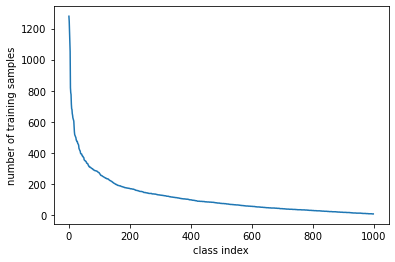

In [20]:
df.sort_values(by='label_count', ascending=False).reset_index().label_count.plot(xlabel='class index', ylabel='number of training samples')

In [21]:
df['w1'] = w1
df['w2'] = w2
df['cls_norm_ce'] = first_dot_product 
df['cls_norm_cekl'] = second_dot_product

In [29]:
df_sorted = df.sort_values(by="label_count", ascending=False)

<AxesSubplot:xlabel='class index sorted from low to high', ylabel='w1'>

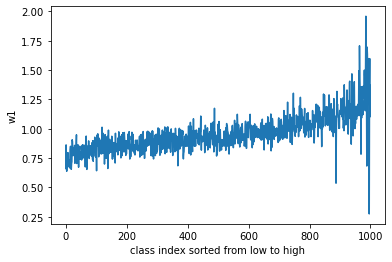

In [30]:
df_sorted['w1'].reset_index()['w1'].plot(xlabel='class index sorted from low to high', ylabel='w1')

<AxesSubplot:>

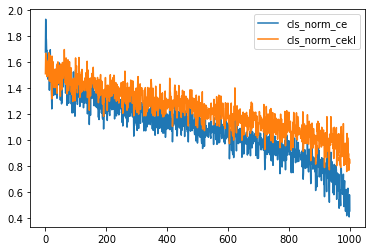

In [33]:
df_sorted['cls_norm_ce'].reset_index()['cls_norm_ce'].plot(legend=True)
df_sorted['cls_norm_cekl'].reset_index()['cls_norm_cekl'].plot(legend=True)

<AxesSubplot:xlabel='class index sorted from low to high', ylabel='w2'>

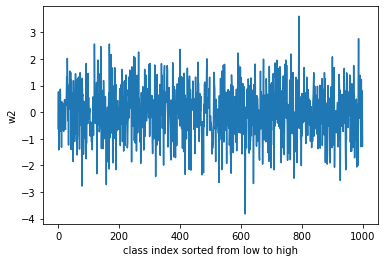

In [16]:
df_sorted['w2'].reset_index()['w2'].plot(xlabel='class index sorted from low to high', ylabel='w2')

# Temperature Softmax

In [33]:
a = torch.tensor([7., 5., 2., 5., 10., 3.])
result = []
x = [0,1,2,3,4,5]
for t in [0.1, 1, 2, 10]:
    result.append(torch.nn.functional.softmax(a/t).tolist())

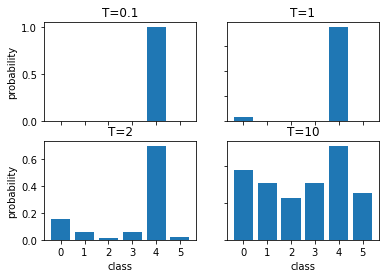

In [46]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].bar(x, result[0])
axs[0, 0].set_title('T=0.1')
axs[0, 0].set_xticks(x)
axs[0, 1].bar(x, result[1])
axs[0, 1].set_title('T=1')
axs[0, 1].set_xticks(x)
axs[1, 0].bar(x, result[2])
axs[1, 0].set_title('T=2')
axs[1, 0].set_xticks(x)
axs[1, 1].bar(x, result[3])
axs[1, 1].set_title('T=10')
axs[1, 1].set_xticks(x)
for ax in axs.flat:
    ax.set(xlabel='class', ylabel='probability')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# sigmoid attention weight

In [2]:
df = pd.read_csv("sigmoid_weight.csv")

In [5]:
df_sorted = df.sort_values(by="freq")

<AxesSubplot:xlabel='freq'>

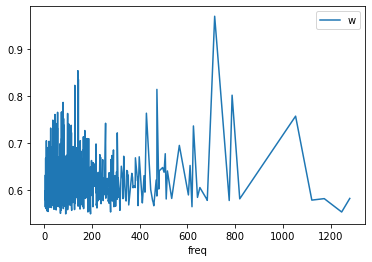

In [14]:
df_sorted.reset_index().plot(x='freq', y='w')

In [6]:
with open("test_loss_dict.pkl", 'rb') as f:
    data = pickle.load(f)